## Data Preprocessing

Data Srouces:
* JHU Covid Case Data
* OWID Covid Data
* Apple Mobility Data
* Google Trends Data

Processing:
* Aggregation
* Rolling
* Outlier Removal

In [1]:
# Import necessities
import os
import datetime
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
# All file paths of raw data
data_path = {
    'confirmed': './data/time_series_covid19_confirmed_global.csv',
    'deaths': './data/time_series_covid19_deaths_global.csv',
    'recovered': './data/time_series_covid19_recovered_global.csv',
    'mobility': './data/applemobilitytrends-2021-03-19.csv',
    'trends': './data/trends_data.csv',
    'owid': './data/owid-covid-data.csv',
}

# Reading in data in csv format
data_df = dict()
for key, value in data_path.items():
    data_df[key] = pd.read_csv(value)

# Droppoing useless columns
data_df['confirmed'] = data_df['confirmed'].iloc[:, 4:-3]
data_df['deaths'] = data_df['deaths'].iloc[:, 4:-3]
data_df['recovered'] = data_df['recovered'].iloc[:, 4:-3]
data_df['mobility'] = data_df['mobility'].iloc[:, 6:-3]

C:\Users\Gao\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Dataset construction
dates = data_df['confirmed'].keys()
dataset = pd.DataFrame({'dates': dates})

# Calculate the total number of differet cases
for split in ['confirmed', 'deaths', 'recovered']:
    dataset[split] = data_df[split].apply(lambda x:x.sum()).values
dataset['unrecovered'] = dataset['confirmed'] - dataset['deaths'] - dataset['recovered']
# Calculate the increments of each group to the previous day
for split in ['confirmed', 'deaths', 'recovered', 'unrecovered']:
    # Calculating the increments by subtracting the shifted column from the original one
    dataset[split + '_increment'] = (dataset[split] - dataset[split].shift(1)).values
    # The first element is NaN and should be modified to 0
    dataset[split + '_increment'].iloc[0] = 0
# Calculate the death rate and recovered rate
dataset['death_rate'] = dataset['deaths'] / dataset['confirmed']
dataset['recovered_rate'] = dataset['recovered'] / dataset['confirmed']

# Add mobilities to the dataset
dataset.loc[:,'mobility'] = data_df['mobility'].sum().values[9:]

# Add vaccinations, tests, hospitalizations, and ages data to the dataset
owid = data_df['owid'].groupby('date').agg({'people_vaccinated': 'sum', 'icu_patients': 'sum', 'hosp_patients': 'sum', 'total_tests': 'sum', 'median_age': 'mean'})[21:-4]
for split in ['people_vaccinated', 'total_tests', 'icu_patients', 'hosp_patients', 'median_age']:
    dataset[split] = owid[split].values

# Add trends data to the dataset
dataset['trends_covid'] = data_df['trends']['COVID']
dataset['trends_vaccine'] = data_df['trends']['vaccine']

# Change dates to integers [0, len(dates)]
dataset['dates'] = [i for i in range(len(dates))]

# Calculate average with sliding windows to smooth the data
dataset_rolling = dataset.rolling(7, min_periods=0).mean()

C:\Users\Gao\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
dataset

,dates,confirmed,deaths,recovered,unrecovered,confirmed_increment,deaths_increment,recovered_increment,unrecovered_increment,death_rate,recovered_rate,mobility,people_vaccinated,total_tests,icu_patients,hosp_patients,median_age,trends_covid,trends_vaccine
0,0,557,17,30,510,0.0,0.0,0.0,0.0,0.030521,0.053860,474849.13,0.0,4.141000e+03,0.0,0.0,37.210000,0.0,4.0
1,1,655,18,32,605,98.0,1.0,2.0,95.0,0.027481,0.048855,493538.04,0.0,4.162000e+03,0.0,0.0,37.258333,0.0,3.0
2,2,941,26,39,876,286.0,8.0,7.0,271.0,0.027630,0.041445,585412.09,0.0,4.469000e+03,0.0,0.0,38.014286,0.0,3.0
3,3,1433,42,42,1349,492.0,16.0,3.0,473.0,0.029309,0.029309,591706.04,0.0,4.670000e+03,0.0,0.0,36.693750,0.0,3.0
4,4,2118,56,56,2006,685.0,14.0,14.0,657.0,0.026440,0.026440,442683.53,0.0,5.372000e+03,0.0,0.0,37.022222,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,415,119060483,2639449,67397676,49023358,489009.0,9617.0,268555.0,210837.0,0.022169,0.566079,0.00,652709529.0,1.148220e+09,23837.0,155388.0,30.253261,71.0,100.0
416,416,119515052,2648162,67650277,49216613,454569.0,8713.0,252601.0,193255.0,0.022158,0.566040,687644.94,672638963.0,1.102975e+09,23869.0,155634.0,30.253261,65.0,83.0
417,417,119875203,2653652,67895977,49325574,360151.0,5490.0,245700.0,108961.0,0.022137,0.566389,544635.66,681099264.0,1.287921e+09,15032.0,121565.0,30.204372,59.0,78.0
418,418,120224301,2660456,68185846,49377999,349098.0,6804.0,289869.0,52425.0,0.022129,0.567155,559776.16,701588119.0,1.172320e+09,1840.0,10447.0,30.204372,67.0,94.0


In [5]:
dataset.to_csv('./data/dataset.csv')
dataset_rolling.to_csv('./data/dataset_rolling.csv')

## Plots

In [5]:
def plot(target):
    ''' Plot the given target feature in dataset
    param target: plotting target
    '''
    plt.figure(figsize=(10, 8))
    plt.title(target)
    plt.plot(dataset[target], label='raw data')
    plt.plot(dataset_rolling[target], label='smoothing data')
    plt.legend()
    plt.show()

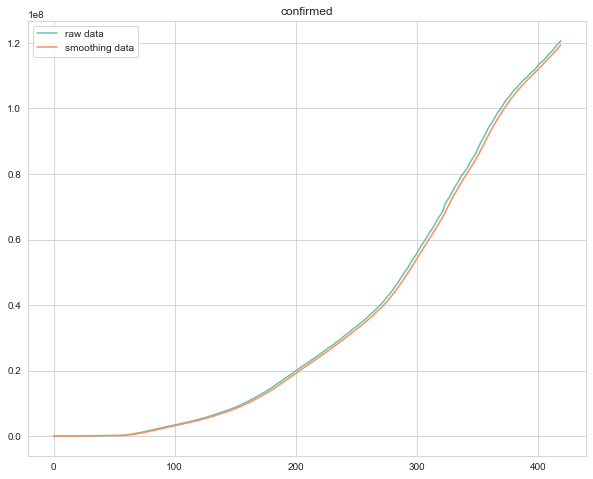

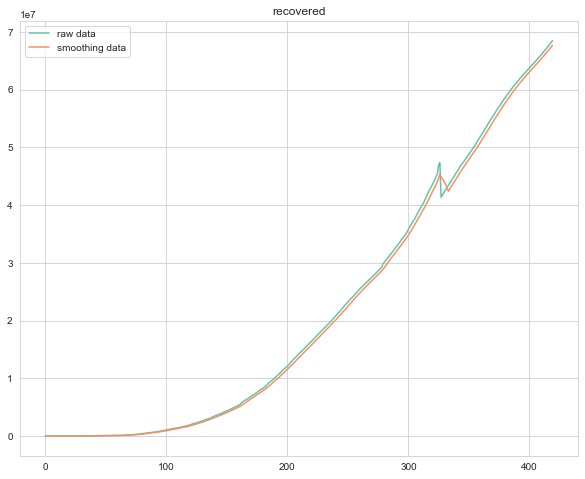

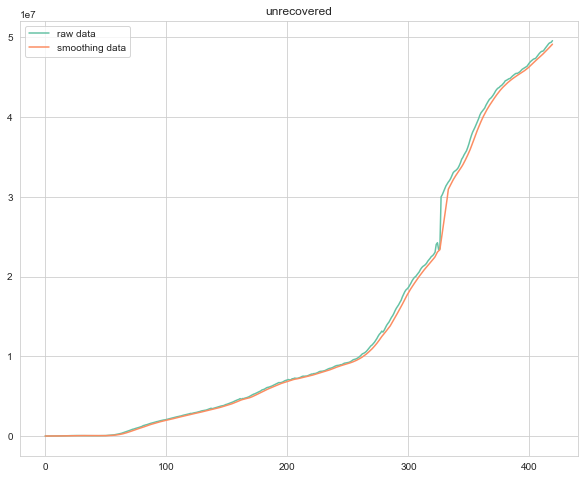

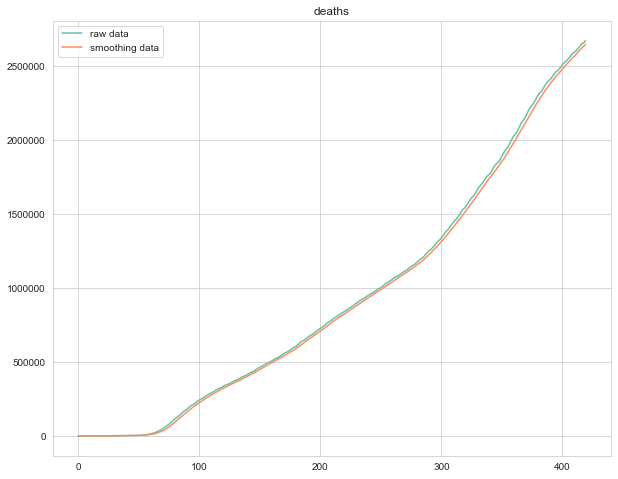

In [31]:
for split in ['confirmed', 'recovered', 'unrecovered', 'deaths']:
    plot(split)

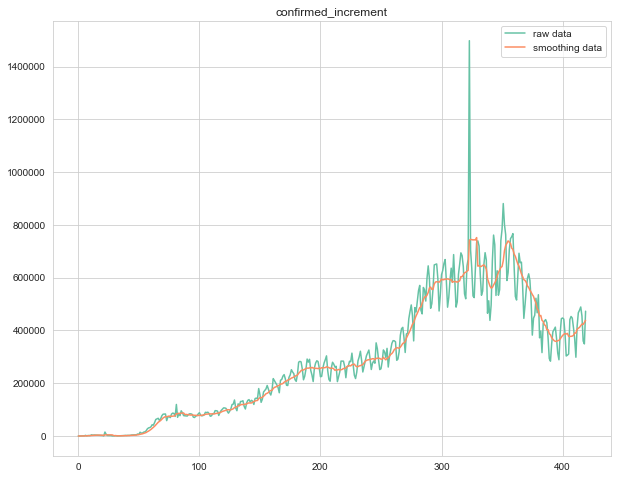

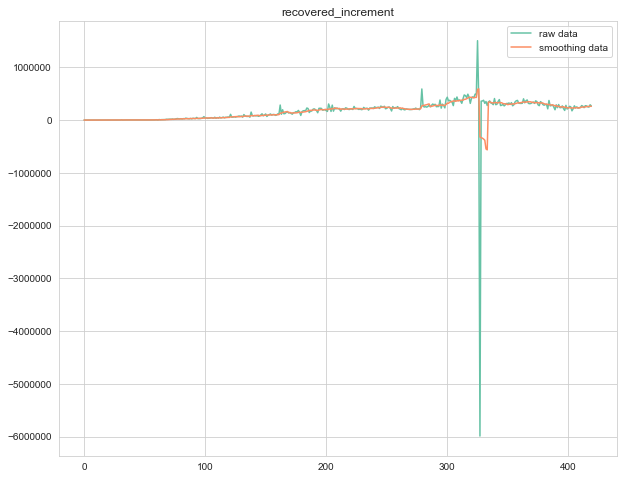

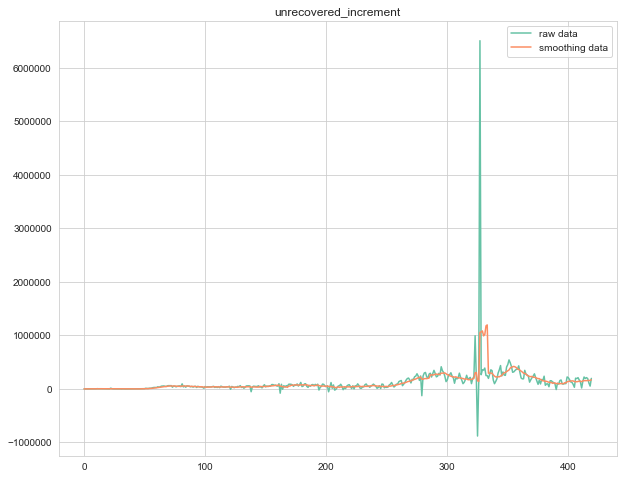

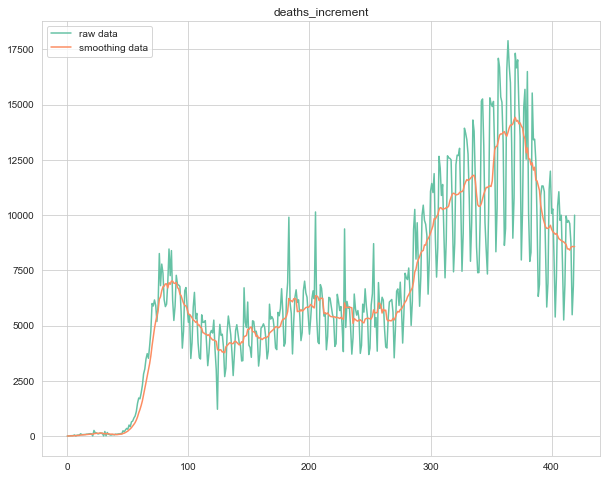

In [32]:
for split in ['confirmed_increment', 'recovered_increment', 'unrecovered_increment', 'deaths_increment']:
    plot(split)

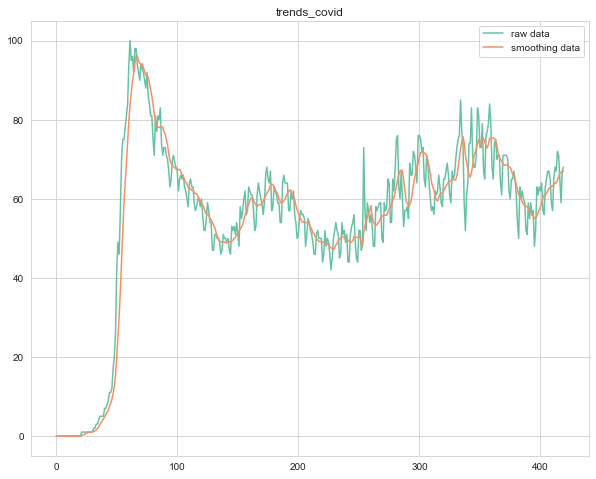

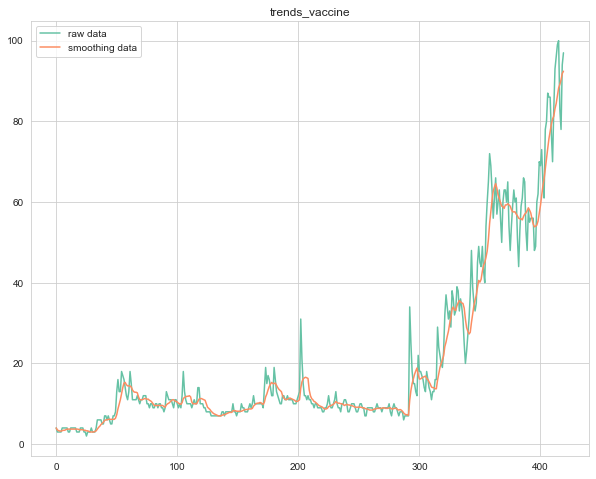

In [35]:
for split in ['trends_covid', 'trends_vaccine']:
    plot(split)

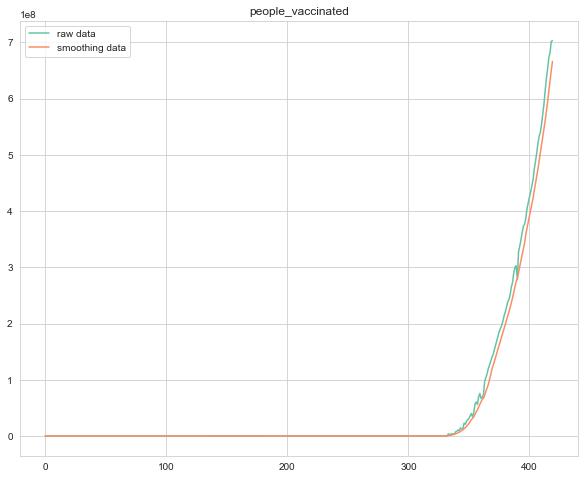

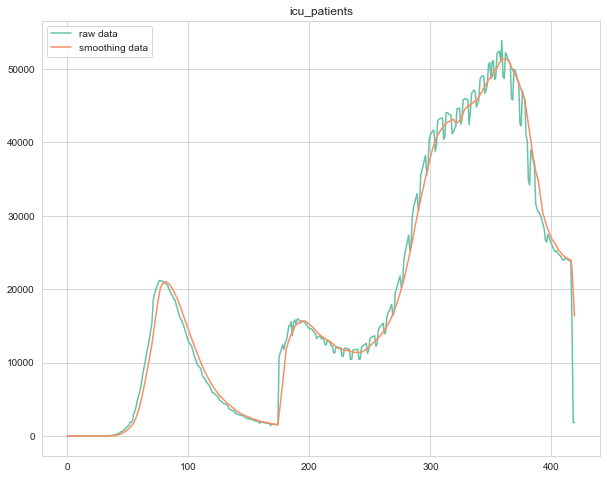

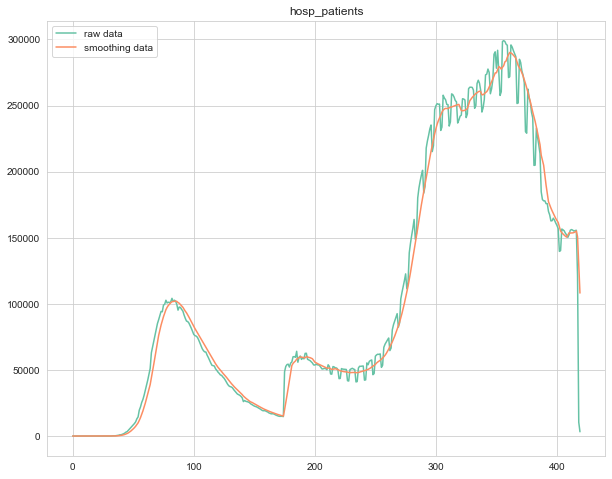

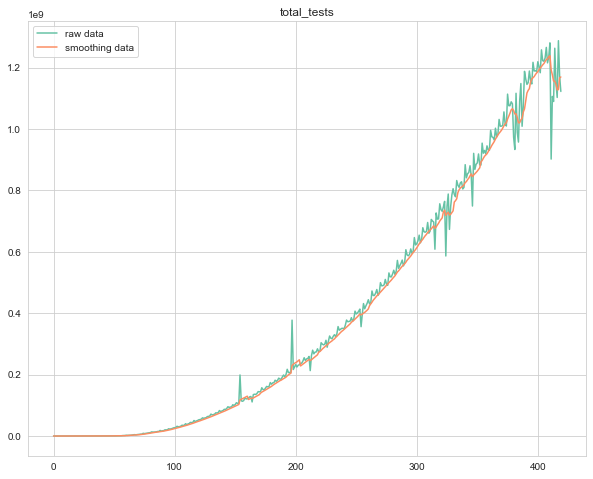

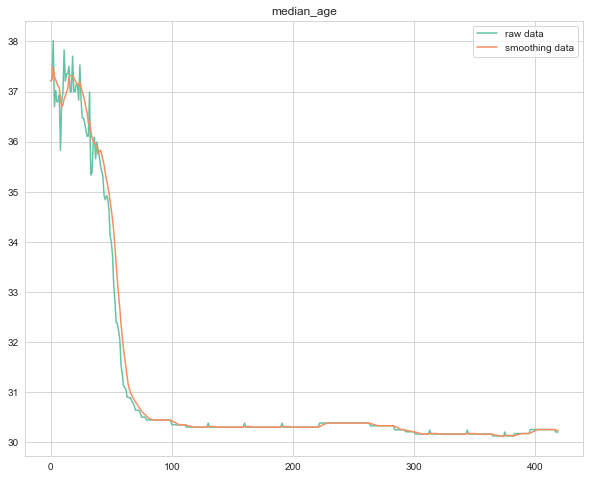

In [34]:
for split in ['people_vaccinated', 'icu_patients', 'hosp_patients', 'total_tests', 'median_age']:
    plot(split)

## Outlier Removal

In [16]:
dataset[dataset['recovered_increment']<0]

,dates,confirmed,deaths,recovered,unrecovered,confirmed_increment,deaths_increment,recovered_increment,unrecovered_increment,death_rate,recovered_rate,mobility,people_vaccinated,total_tests,icu_patients,hosp_patients,median_age,trends_covid,trends_vaccine
327,327,72958747,1626136,41338399,29994212,524515.0,9175.0,-5989997.0,6505337.0,0.022288,0.5666,487305.38,86465.0,673194707.0,45758.0,262691.0,30.163536,67.0,38.0


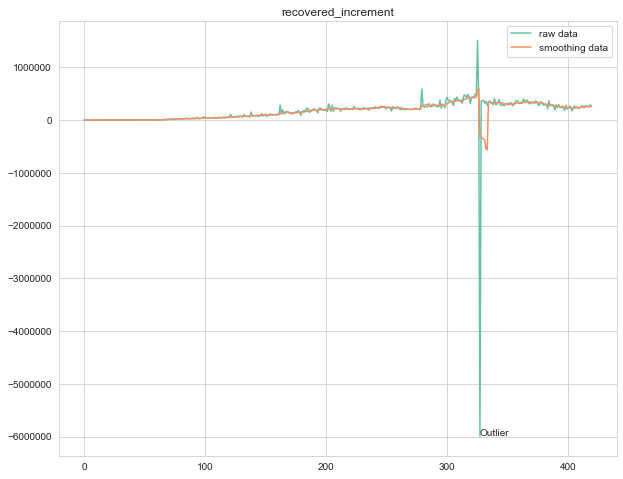

In [15]:
target = 'recovered_increment'
plt.figure(figsize=(10, 8))
plt.title(target)
plt.plot(dataset[target], label='raw data')
plt.plot(dataset_rolling[target], label='smoothing data')
plt.text(327, -5989997.0, 'Outlier')
plt.legend()
plt.show()

In [71]:
# Locating the outliers in recovered dataset
recovered_df = pd.read_csv('./data/time_series_covid19_recovered_global.csv')
print(dataset['recovered'][326:328])
print(data_df['recovered'].columns[327])

326    47328396
327    41338399
Name: recovered, dtype: int64
12/14/20


In [37]:
# Which country is the outlier data from
for k, v in enumerate(data_df['recovered']['12/14/20']):
    if recovered_df['12/13/20'][k] > v:
        print(recovered_df['Country/Region'][k])

US


In [61]:
recovered_df[recovered_df['Country/Region']=='US'].values[0][4:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 8, 12, 12, 12, 12, 17, 17, 105, 121, 147, 176, 178,
       178, 348, 361, 681, 869, 1072, 2665, 5644, 7024, 8474, 9001, 9707,
       14652, 17448, 19581, 21763, 23559, 25410, 28790, 31270, 32988,
       43482, 47763, 52096, 54703, 58545, 64840, 70337, 72329, 75204,
       77366, 80203, 99079, 100372, 106988, 111424, 115936, 120720,
       153947, 164015, 175382, 180152, 187180, 189791, 189910, 195036,
       198993, 212534, 216169, 232733, 230287, 243430, 246414, 250747,
       268376, 272265, 283178, 289392, 294312, 298418, 350135, 361239,
       366736, 379157, 384902, 391508, 399991, 406446, 416461, 444758,
       458231, 463868, 479258, 485002, 491706, 500849, 506367, 518522,
       524855, 533504, 540292, 547386, 556606, 561816, 576334, 583503,
       592191, 599115, 606715, 617460, 622133, 640198, 647548, 656161,
 

Text(320, 0, 'Outlier')

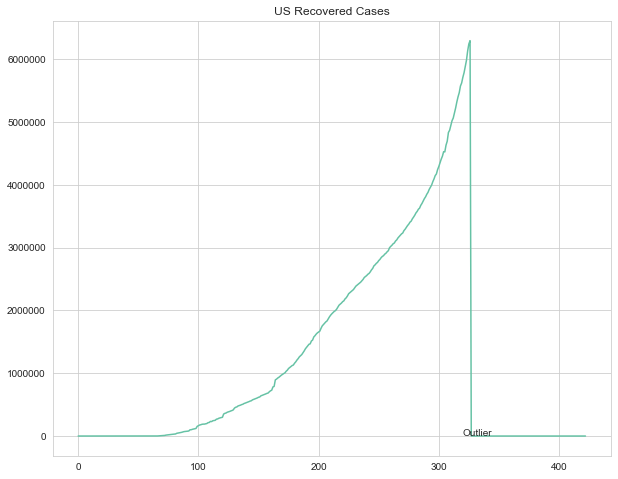

In [65]:
plt.figure(figsize=(10, 8))
plt.title('US Recovered Cases')
plt.plot(recovered_df[recovered_df['Country/Region']=='US'].values[0][4:])
plt.text(320, 0, 'Outlier')